In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from types import SimpleNamespace
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import wavfile
from scipy.signal import correlate, decimate, find_peaks
from scipy.fftpack import fft
from scipy.signal import argrelextrema, fftconvolve


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/test"))

# Any results you write to the current directory are saved as output.from scipy.signal import argrelextrema, fftconvolve

['F4.wav', 'M3.wav', 'F2.wav', 'F3.wav', 'M2.wav', 'F1.wav', 'M4.wav', 'M5.wav', 'F5.wav', 'M1.wav']


[-0.37160627 -0.01756289  2.42473548  1.37794961  0.63805723 -0.20149245
  0.27094871  1.17738866 -1.49966514  0.14708723  1.15203823  1.05890025
  0.27124285  0.7225944   0.72665463  1.22314484 -0.89253263]


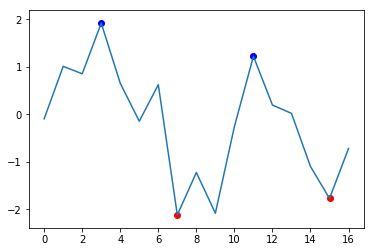

In [2]:
   
import scipy.fftpack as sf
import numpy as np
import matplotlib.pyplot as plt

import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)
from matplotlib.pyplot import plot, scatter, show
series = np.array([0.6,0,0,2,0,0,0,-2.7,0,0,0,2,0,0,0,-2,0])
series = series +np.random.normal(0,1,len(series))
print( np.random.normal(0,1,len(series)))
maxtab, mintab = peakdet(series,.9)
plot(series)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
show()


In [3]:
from fractions import gcd
def freq_pitch(frame, sfreq, n_fft=2048, threshold = 0.46, fmin = 50, fmax = 400 ):
    # Process

    # Calculate autocorrelation using scipy correlate
    frame = frame.astype(np.float)
    frame -= frame.mean()
    amax = np.abs(frame).max()
    if amax > 0:
        frame /= amax
    else:
        return 0
    
    dft_X = np.abs(np.fft.fft(frame,n=n_fft))**2
    dft_X = dft_X[0:int(n_fft/2)]
    
    
    corr = correlate(frame, frame)
    # keep the positive part
    corr = corr[len(corr)//2:]

    # Find the first minimum
    dcorr = np.diff(corr)
    rmin = np.where(dcorr > 0)[0]
    if len(rmin) > 0:
        rmin1 = rmin[0]
    else:
        return 0
    # Find the next peak
    peak = np.argmax(corr[rmin1:]) + rmin1
    rmax = corr[peak]/corr[0]
    f0 = sfreq/peak


    if rmax > threshold and f0<=fmax and f0>= fmin:
        #frequ methode
        #maxims, minims = peakdet(dft_X[0:int(n_fft/2)], .6)
        '''figures
        plt.figure()
        plt.plot(frame)
        plt.xlabel('time in seconds')
        plt.ylabel('amplitude')
        plt.title('Waveform')
        plt.figure()
        dft_axis = np.arange(len(dft_X[0:int(n_fft/4)]))
        dft_axis = [(elem*sfreq)/n_fft for elem in dft_axis]
        plt.plot(dft_X)
        #plt.scatter(array(maxims)[0:3,0], array(maxims)[0:3,1], color='blue')
        plt.xlabel('f')
        plt.ylabel('amplitude')
        plt.title('DFT')
        '''

    
        #DOWN_SAMPLES
        dft_X_v2 = np.abs(decimate(dft_X[0:int(n_fft/2)], 2))
        dft_X_v3 = np.abs(decimate(dft_X[0:int(n_fft/2)], 3))
        dft_X_v4 = np.abs(decimate(dft_X[0:int(n_fft/2)], 4))
        n_samples = len(dft_X_v4)
        total_spectre = dft_X[0:n_samples]*dft_X_v2[0:n_samples]*dft_X_v3[0:n_samples]*dft_X_v4
        total_spectre = total_spectre/ np.max(total_spectre)
        #maxtab,mintab = peakdet(total_spectre,1000)
        pos, _ =  find_peaks(total_spectre,height=0.15)
        
        if (len(pos)==1): t=pos[0]
        elif (pos[0]>pos[1]): t=pos[0]
        else: t=pos[1]
        
        #t=pos[0]
        
        '''
        plt.figure()
        plt.plot(total_spectre)
        plt.scatter(t,0)
        plt.xlim(0,128)
       
        plt.figure()
        plt.plot(dft_X, c = 'b')
        plt.xlim(0,128)

        plt.figure()
        plt.plot(dft_X_v2[0:int(n_fft/2)], c = 'r')
        plt.xlim(0,128)

        plt.figure()
        plt.plot(dft_X_v3[0:int(n_fft/3)], c = 'g')
        plt.xlim(0,128)
        plt.show()
        '''
        #maxims_loc = array(maxims)[0:2,0]
        #f0 = gcd(maxims_loc[0], maxims_loc[1])
        # Convert position to Hz

        f0 = (t*sfreq)/n_fft
        if f0>=fmin and f0 <= fmax: 
            #print ("Selected f0: {}".format(f0))
            return f0
        else:
            return 0
    else:
        return 0




In [4]:
class Counters:
    def __init__(self, gross_threshold=0.2):
        self.num_voiced = 0
        self.num_unvoiced = 0
        self.num_voiced_unvoiced = 0
        self.num_unvoiced_voiced = 0
        self.num_voiced_voiced = 0
        self.num_gross_errors = 0
        self.fine_error = 0
        self.e2 = 0
        self.gross_threshold = gross_threshold
        self.nfiles = 0

    def add(self, other):
        if other is not None:
            self.num_voiced += other.num_voiced
            self.num_unvoiced += other.num_unvoiced
            self.num_voiced_unvoiced += other.num_voiced_unvoiced
            self.num_unvoiced_voiced += other.num_unvoiced_voiced
            self.num_voiced_voiced += other.num_voiced_voiced
            self.num_gross_errors += other.num_gross_errors
            self.fine_error += other.fine_error
            self.e2 += other.e2
            self.nfiles += 1

    def __repr__(self):
        nframes = self.num_voiced + self.num_unvoiced
        if self.nfiles > 0:
            self.fine_error /= self.nfiles
        str = [
            f"Num. frames:\t{self.num_unvoiced + self.num_voiced} = {self.num_unvoiced} unvoiced + {self.num_voiced} voiced",
            f"Unvoiced frames as voiced:\t{self.num_unvoiced_voiced}/{self.num_unvoiced} ({100*self.num_unvoiced_voiced/self.num_unvoiced:.2f}%)",
            f"Voiced frames as unvoiced:\t{self.num_voiced_unvoiced}/{self.num_voiced} ({100*self.num_voiced_unvoiced/self.num_voiced:.2f}%)",
            f"Gross voiced errors (>{100*self.gross_threshold}%):\t{self.num_gross_errors}/{self.num_voiced_voiced} ({100*self.num_gross_errors/self.num_voiced_voiced:.2f}%)",
            f"MSE of fine errors:\t{100*self.fine_error:.2f}%",
            f"RMSE:\t{np.sqrt(self.e2/nframes):.2f}"
        ]
        return '\n'.join(str)

In [5]:
def compare(fref, pitch):
    vref = np.loadtxt(fref)
    vtest = np.array(pitch)

    diff_frames = len(vref) - len(vtest)
    if abs(diff_frames) > 5:
        print(f"Error: number of frames in ref ({len(vref)}) != number of frames in test ({len(vtest)})")
        return None
    elif diff_frames > 0:
        vref = np.resize(vref, vtest.shape)
    elif diff_frames < 0:
        vtest = np.resize(vtest, vref.shape)

    counters = Counters()
    counters.num_voiced = np.count_nonzero(vref)
    counters.num_unvoiced = len(vref) - counters.num_voiced
    counters.num_unvoiced_voiced = np.count_nonzero(np.logical_and(vref == 0, vtest != 0))
    counters.num_voiced_unvoiced = np.count_nonzero(np.logical_and(vref != 0, vtest == 0))

    voiced_voiced = np.logical_and(vref != 0, vtest != 0)
    counters.num_voiced_voiced = np.count_nonzero(voiced_voiced)

    f = np.absolute(vref[voiced_voiced] - vtest[voiced_voiced])/vref[voiced_voiced]
    gross_errors = f > counters.gross_threshold
    counters.num_gross_errors = np.count_nonzero(gross_errors)
    fine_errors = np.logical_not(gross_errors)
    counters.fine_error = np.sqrt(np.square(f[fine_errors]).mean())
    counters.e2 = np.square(vref - vtest).sum()

    return counters

In [6]:
from scipy.signal import butter, lfilter, freqz, medfilt, hilbert
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def wav2f0(options, gui):
    fs = open(options.submission, 'w') if options.submission is not None else None
    totalCounters = Counters()
    with open(gui) as f:
        if fs is not None:
            print('id,frequency', file=fs)
        
        for line in f:
            prev_f0=0
            line = line.strip()
            if len(line) == 0:
                continue
            filename = os.path.join(options.datadir, line + ".wav")
            f0ref_filename = os.path.join(options.datadir, line + ".f0ref")
            print("Processing:", filename)
            sfreq, data = wavfile.read(filename)
            nsamples = len(data)

            # From miliseconds to samples
            ns_windowlength = int(round((options.windowlength * sfreq) / 1000))
            ns_frameshift = int(round((options.frameshift * sfreq) / 1000))
            ns_left_padding = int(round((options.left_padding * sfreq) / 1000))
            ns_right_padding = int(round((options.right_padding * sfreq) / 1000))
            pitch = []
             
            #Pre-processing
            cutoff_freq = 900
            n_coeficients = 10
            
            
            print(len(data))
            
            # Get the filter coefficients so we can check its frequency response.
            b, a = butter_lowpass(cutoff_freq, sfreq, n_coeficients)

            # Filter the signal
            data = butter_lowpass_filter(data, cutoff_freq, sfreq, n_coeficients)
            # Preprocessing (centre-clipping)
            print("Max from frame: {}".format(np.max(data)))
            centreclip = 200
            data = (abs(data) > centreclip).astype(np.int) * data
            
            for id, ini in enumerate(range(-ns_left_padding, nsamples - ns_windowlength + ns_right_padding + 1, ns_frameshift)):
                first_sample = max(0, ini)
                last_sample = min(nsamples, ini + ns_windowlength)
                frame = data[first_sample:last_sample]
                f0 = freq_pitch(frame, sfreq)
                if fs is not None:
                    print(line + '_' + str(id) + ',', f0, file=fs)
                pitch.append(f0)
            window_size = 3
            pitch = medfilt(pitch, window_size)
            if os.path.isfile(f0ref_filename):
                counters = compare(f0ref_filename, pitch)
                totalCounters.add(counters)
            '''
            plt.figure()
            plt.plot(np.loadtxt(f0ref_filename),c='b')
            plt.plot(pitch,c='r')
            plt.show()
            '''
            
            
            
    if totalCounters.num_voiced + totalCounters.num_unvoiced > 0:
        print("### Summary")
        print(totalCounters)
        print("-------------------------------\n")

In [7]:
fda_ue_options = SimpleNamespace(
    windowlength=32, frameshift=15, left_padding=16, right_padding=16, datadir='../input', submission=None)
wav2f0(fda_ue_options, '../input/fda_ue.gui')

Processing: ../input/fda_ue/rl001.wav
30000
Max from frame: 8389.07906825858
Processing: ../input/fda_ue/rl002.wav
40000
Max from frame: 7149.445186520171


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[n

Processing: ../input/fda_ue/rl003.wav
40000
Max from frame: 7220.465175758988
Processing: ../input/fda_ue/rl004.wav
32000
Max from frame: 7425.98074195409
Processing: ../input/fda_ue/rl005.wav
30000
Max from frame: 9636.854776110566
Processing: ../input/fda_ue/rl006.wav
40000
Max from frame: 4934.095829867926
Processing: ../input/fda_ue/rl007.wav
30000
Max from frame: 6929.213794251577
Processing: ../input/fda_ue/rl008.wav
40000
Max from frame: 7618.81208167435
Processing: ../input/fda_ue/rl009.wav
32000
Max from frame: 8886.246415914342
Processing: ../input/fda_ue/rl010.wav
50000
Max from frame: 9950.276925018527
Processing: ../input/fda_ue/rl011.wav
40000
Max from frame: 10592.233767934371
Processing: ../input/fda_ue/rl012.wav
34000
Max from frame: 5059.9639222353
Processing: ../input/fda_ue/rl013.wav
34000
Max from frame: 7097.800140579308
Processing: ../input/fda_ue/rl014.wav
30000
Max from frame: 6481.69315087743
Processing: ../input/fda_ue/rl015.wav
60000
Max from frame: 10939.18

In [8]:
test_options = SimpleNamespace(
    windowlength=26.5, frameshift=10, left_padding=13.25, right_padding=7, datadir='../input/test', submission='submission.csv')
wav2f0(test_options, '../input/test.gui')

Processing: ../input/test/F1.wav
644201
Max from frame: 16810.72312911893


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[n

Processing: ../input/test/F2.wav
674001
Max from frame: 10909.376577509376
Processing: ../input/test/F3.wav
610001
Max from frame: 9742.522612139759
Processing: ../input/test/F4.wav
632001
Max from frame: 14782.518545910414
Processing: ../input/test/F5.wav
774001
Max from frame: 19469.822056512065
Processing: ../input/test/M1.wav
747501
Max from frame: 12590.515162252921
Processing: ../input/test/M2.wav
637501
Max from frame: 9531.776437771496
Processing: ../input/test/M3.wav
543501
Max from frame: 12191.05450278864
Processing: ../input/test/M4.wav
674001
Max from frame: 9253.483599825751
Processing: ../input/test/M5.wav
806001
Max from frame: 13245.04100838013
